# T cell epitopes of SARS-CoV2

## Methods

* Load GIS cov2 sequences
* Translate to proteins
* Calculate conservation of regions
* Predict epitopes for reference
* 

## References

* A. Grifoni et al., “A sequence homology and bioinformatic approach can predict candidate targets for immune responses to SARS-CoV-2,” Cell Host Microbe, pp. 1–10, 2020.
* V. Baruah and S. Bose, “Immunoinformatics-aided identification of T cell and B cell epitopes in the surface glycoprotein of 2019-nCoV,” J. Med. Virol., no. February, pp. 495–500, 2020.
* S. F. Ahmed, A. A. Quadeer, and M. R. McKay, “Preliminary Identification of Potential Vaccine Targets for the COVID-19 Coronavirus (SARS-CoV-2) Based on SARS-CoV Immunological Studies.,” Viruses, vol. 12, no. 3, 2020.

In [19]:
import os, math, time, pickle, subprocess
from importlib import reload
from collections import OrderedDict
import numpy as np
import pandas as pd
pd.set_option('display.width', 150)
import epitopepredict as ep
from epitopepredict import base, sequtils, plotting, peptutils, analysis
from IPython.display import display, HTML, Image
%matplotlib inline
import matplotlib as mpl
import pylab as plt
import seaborn as sns
import pybioviz
from bokeh.io import show, output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
ep.mhc1_presets

['mhc1_supertypes',
 'us_caucasion_mhc1',
 'us_african_mhc1',
 'broad_coverage_mhc1']

In [2]:
m1_alleles = ep.get_preset_alleles('broad_coverage_mhc1')
m2_alleles = ep.get_preset_alleles('mhc2_supertypes')

In [3]:
sc2 = ep.genbank_to_dataframe('NC_045512.gb',cds=True)
sc2 = sc2.drop_duplicates('gene')
sc2

,type,protein_id,locus_tag,gene,db_xref,product,note,translation,pseudo,pseudogene,start,end,strand,length,order
3,CDS,YP_009724389.1,GU280_gp01,orf1ab,GeneID:43740578,orf1ab polyprotein,pp1ab; translated by -1 ribosomal frameshift,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...,NaN,NaN,265,21555,1,7096,1
24,CDS,YP_009724390.1,GU280_gp02,S,GeneID:43740568,surface glycoprotein,structural protein; spike protein,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,NaN,NaN,21562,25384,1,1273,3
26,CDS,YP_009724391.1,GU280_gp03,ORF3a,GeneID:43740569,ORF3a protein,NaN,MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWL...,NaN,NaN,25392,26220,1,275,4
28,CDS,YP_009724392.1,GU280_gp04,E,GeneID:43740570,envelope protein,ORF4; structural protein; E protein,MYSFVSEETGTLIVNSVLLFLAFVVFLLVTLAILTALRLCAYCCNI...,NaN,NaN,26244,26472,1,75,5
30,CDS,YP_009724393.1,GU280_gp05,M,GeneID:43740571,membrane glycoprotein,ORF5; structural protein,MADSNGTITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANRNRFL...,NaN,NaN,26522,27191,1,222,6
32,CDS,YP_009724394.1,GU280_gp06,ORF6,GeneID:43740572,ORF6 protein,NaN,MFHLVDFQVTIAEILLIIMRTFKVSIWNLDYIINLIIKNLSKSLTE...,NaN,NaN,27201,27387,1,61,7
34,CDS,YP_009724395.1,GU280_gp07,ORF7a,GeneID:43740573,ORF7a protein,NaN,MKIILFLALITLATCELYHYQECVRGTTVLLKEPCSSGTYEGNSPF...,NaN,NaN,27393,27759,1,121,8
36,CDS,YP_009725318.1,GU280_gp08,ORF7b,GeneID:43740574,ORF7b,NaN,MIELSLIDFYLCFLAFLLFLVLIMLIIFWFSLELQDHNETCHA,NaN,NaN,27755,27887,1,43,9
38,CDS,YP_009724396.1,GU280_gp09,ORF8,GeneID:43740577,ORF8 protein,NaN,MKFLVFLGIITTVAAFHQECSLQSCTQHQPYVVDDPCPIHFYSKWY...,NaN,NaN,27893,28259,1,121,10
40,CDS,YP_009724397.2,GU280_gp10,N,GeneID:43740575,nucleocapsid phosphoprotein,ORF9; structural protein,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLP...,NaN,NaN,28273,29533,1,419,11


In [4]:
spike = sc2[sc2.gene=='S'].iloc[0]
spike.translation

'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITG

In [6]:
P1 = base.get_predictor('netmhcpan') 
P1.predict_sequences(sc2, alleles=m1_alleles,cpus=10,path='netmhcpan',overwrite=False)
P2 = base.get_predictor('mhcflurry') 
P2.predict_sequences(sc2, alleles=m1_alleles,cpus=10,path='mhcflurry',overwrite=False)

predictions done for 11 sequences in 26 alleles
results saved to /home/damien/gitprojects/teaching/sarscov2/netmhcpan
predictions done for 11 sequences in 26 alleles
results saved to /home/damien/gitprojects/teaching/sarscov2/mhcflurry


In [7]:
P1.load(path='netmhcpan')
P2.load(path='mhcflurry')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3267: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [114]:
?P.promiscuous_binders

Signature:
P.promiscuous_binders(
    binders=None,
    name=None,
    cutoff=0.95,
    cutoff_method='default',
    n=1,
    unique_core=True,
    **kwargs,
)
Docstring:
Use params for getbinders if no binders provided?
Args:
    binders: can provide a precalculated list of binders
    name: specific protein, optional
    value: to pass to get_binders
    cutoff_method: 'default', 'score' or 'rank'
    cutoff: percentile cutoff for get_binders
    n: min number of alleles
    unique_core: removes peptides with duplicate cores and picks the most
    promiscuous and highest ranked, used for mhc-II predictions
Returns:
    a pandas dataframe
File:      ~/gitprojects/epitopepredict/epitopepredict/base.py
Type:      method


In [8]:
rb = P1.promiscuous_binders(n=3, cutoff_method='rank', cutoff=10)


In [20]:
reload(analysis)
pb1 = P1.promiscuous_binders(n=5, cutoff=.95)
pb2 = P2.promiscuous_binders(n=5, cutoff=.95)
#pb = P.promiscuous_binders(n=3, cutoff=500, cutoff_method='score')
cl1 = analysis.find_clusters(pb1, genome=sc2)
cl2 = analysis.find_clusters(pb2, genome=sc2)

HLA-A*02:03  not in cutoffs
HLA-A*31:01  not in cutoffs
HLA-A*32:01  not in cutoffs
HLA-A*33:01  not in cutoffs
HLA-A*68:01  not in cutoffs
HLA-B*40:01  not in cutoffs
HLA-B*44:02  not in cutoffs


In [ ]:
for n in sc2.locus_tag:
    print (n)
    x = pb1[pb1.name==n]
    print (x)

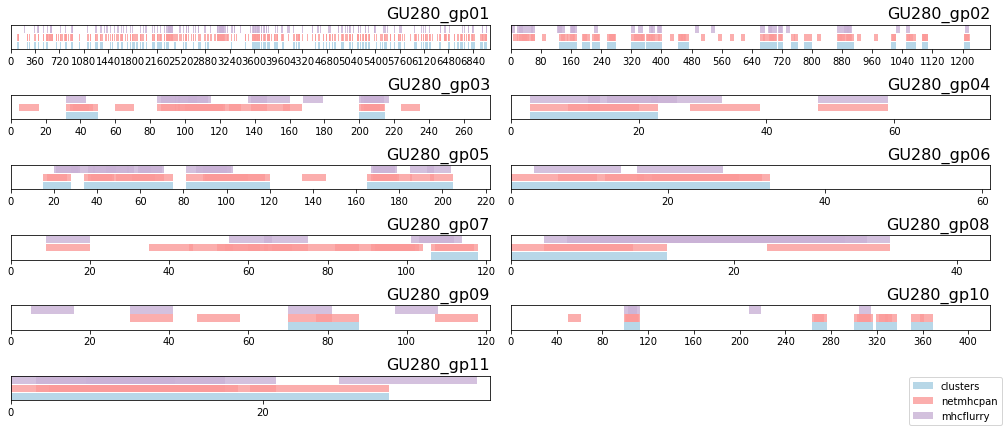

In [13]:
c1 = ep.binders_to_coords(cl1)
c2 = ep.binders_to_coords(cl2)
a = ep.binders_to_coords(pb1)
b = ep.binders_to_coords(pb2)
f = ep.plot_overview(sc2, coords={'clusters':c1,'netmhcpan':a,'mhcflurry':b},
                         cols=2, figsize=(14,6))


In [14]:
cl1[cl1.name=='GU280_gp02']

,name,start,end,binders,length,gene,peptide
5,GU280_gp02,866,911,9,45,S,DEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGV
18,GU280_gp02,129,176,7,47,S,VCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFL
19,GU280_gp02,358,402,7,44,S,SNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVI
21,GU280_gp02,318,356,6,38,S,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRK
22,GU280_gp02,255,279,6,24,S,SGWTAGAAAYYVGYLQPRTFLLKY
25,GU280_gp02,443,472,5,29,S,KVGGNYNYLYRLFRKSNLKPFERDISTEI
26,GU280_gp02,684,707,5,23,S,RSVASQSIIAYTMSLGAENSVAY
41,GU280_gp02,1049,1075,4,26,S,MSFPQSAPHGVVFLHVTYVPAQEKNF
42,GU280_gp02,1092,1109,4,17,S,GVFVSNGTHWFVTQRNF
43,GU280_gp02,1204,1220,4,16,S,KYEQYIKWPWYIWLGF


HLA-A*02:03  not in cutoffs
HLA-A*31:01  not in cutoffs
HLA-A*32:01  not in cutoffs
HLA-A*33:01  not in cutoffs
HLA-A*68:01  not in cutoffs
HLA-B*40:01  not in cutoffs
HLA-B*44:02  not in cutoffs


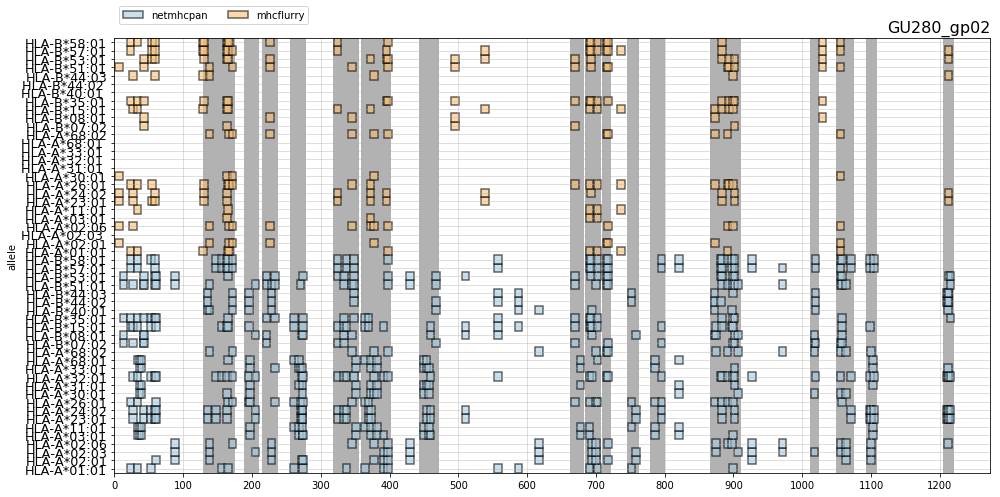

In [18]:
name ='GU280_gp02'
#print (pb[pb.name==name])
ax = ep.plot_tracks([P1,P2],name=name,legend=True,figsize=(14,7),n=5)#,cutoff_method='score')
r = cl1[cl1.name==name]
coords = (list(r.start),list(r.end-r.start))
coords = zip(*coords)
ep.plot_regions(coords, ax, color='gray')
plt.savefig('clusters.png')

In [16]:
plot=ep.bokeh_plot_tracks([P1,P2],name=name,n=5,height=200)#,cutoff_method='score')
show(plot)

HLA-A*02:03  not in cutoffs
HLA-A*31:01  not in cutoffs
HLA-A*32:01  not in cutoffs
HLA-A*33:01  not in cutoffs
HLA-A*68:01  not in cutoffs
HLA-B*40:01  not in cutoffs
HLA-B*44:02  not in cutoffs
HLA-A*02:03  not in cutoffs
HLA-A*31:01  not in cutoffs
HLA-A*32:01  not in cutoffs
HLA-A*33:01  not in cutoffs
HLA-A*68:01  not in cutoffs
HLA-B*40:01  not in cutoffs
HLA-B*44:02  not in cutoffs


In [ ]:
c = analysis.epitope_conservation(seqs, alnrows=alnrows)

## view residues on structure

In [196]:
ranges = list(zip(r.start,r.end))
ranges = [list(range(r[0],r[1])) for r in ranges]

In [39]:
from pymol import cmd

In [184]:
def highlight_residues(residues, chain):
   
    from pymol import stored
    vals = {}   
    for r in residues:
        sel = '(chain %s and resi %s)' %(chain,r)
        cmd.color('red', sel)
    return
    
def find_interacting_residues():
    """Find set of residues"""
   
    from pymol import stored
    vals = {}
    residues = range(1,50)
    offset=3
    for p in residues:
        sel1 = '(c. A and (donor or acceptor) and resi %s)' %p
        cmd.select('near','c. B within 4 of %s' %sel1)
        #cmd.show('stick','near')
        #cmd.color('green', 'near')
        stored.lst=[]
        cmd.iterate('near',"stored.lst.append((chain,resi,resn,name))")
        #print (stored.lst)       
        for r in stored.lst:         
            cmd.show('stick','resi %s' %r[1])
            cmd.color('red','resi %s' %r[1])
    return


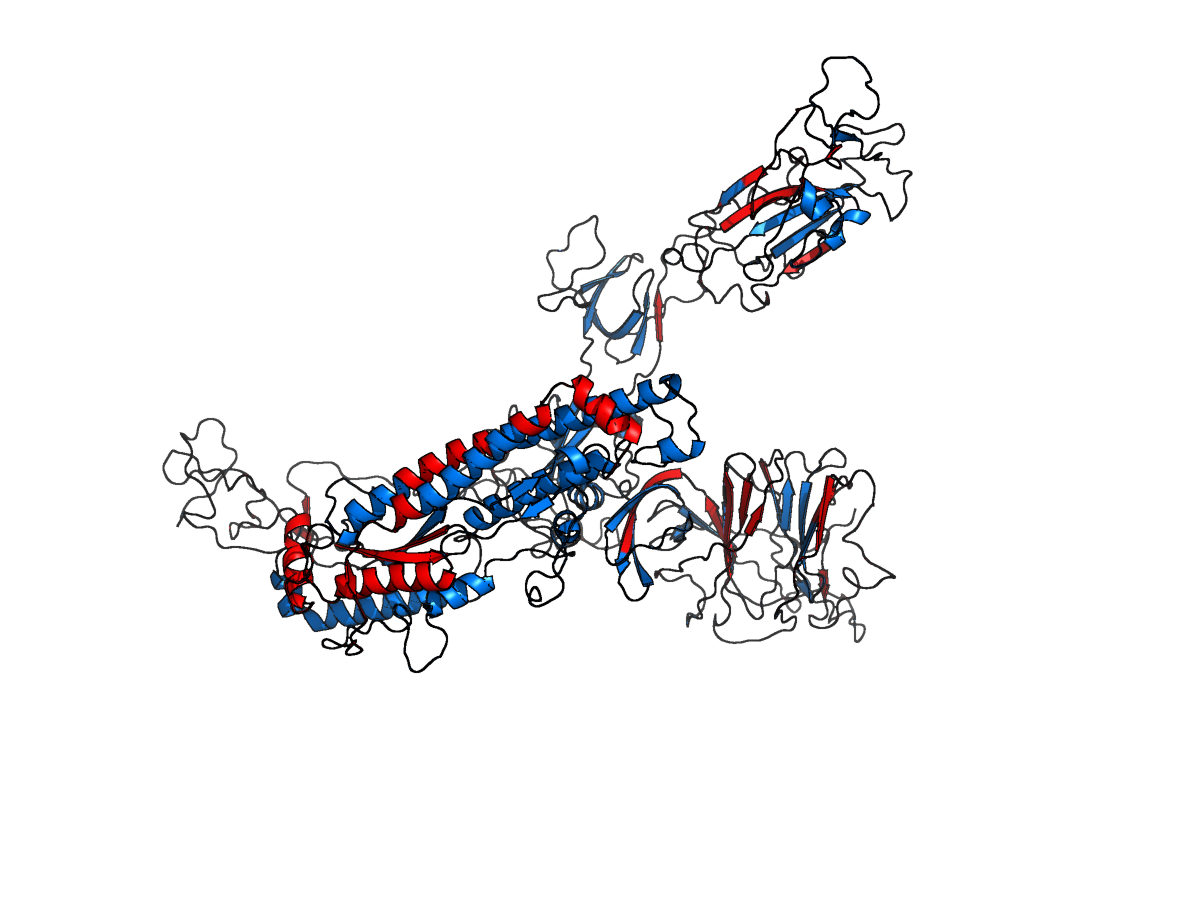

In [207]:
cmd.reinitialize()
#cmd.load('6lzg.pdb')
cmd.load('model_spike.pdb')
cmd.orient()
cmd.remove('resn hoh')
cmd.hide('all')
cmd.show('cartoon','chain C')
cmd.turn('x', -90)
cmd.turn('z', 200)
cmd.bg_color('white')
cmd.color('marine','chain C')
cmd.color('gray','chain D')
#cmd.select('rbd', '(chain C and resi 455+486+493+494+501+505)')
cmd.zoom('chain C')
#cmd.show('sticks', 'rbd')
#cmd.label('rbd and n. c' , 'resn+resi')
cmd.set('label_position', (1,2,3))
#find_interacting_residues()
for x in ranges:
    highlight_residues(x,'C')
cmd.set('ray_trace_mode',1)
cmd.set('ray_trace_gain',0)
cmd.png('model_spike.png', width=1200,dpi=150)
cmd.save('model_spike.pse')
Image(filename='model_spike.png')
